Number of tracks: 886
Pearson r: 0.30887977717494774 p-value: 4.8602271370883485e-21
Spearman rho: 0.36994189478097933 p-value: 4.03640435309153e-30


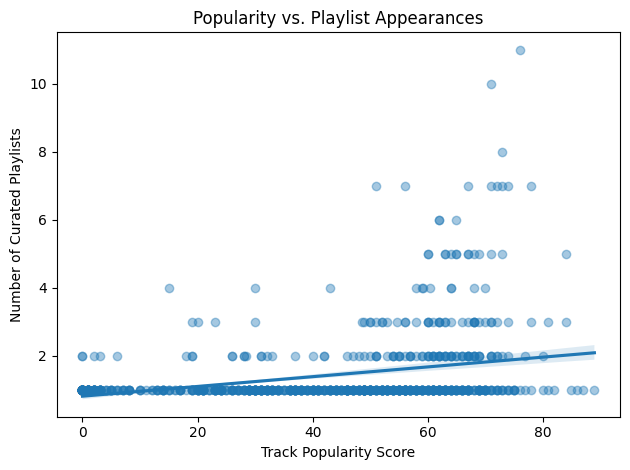

In [12]:
import json
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

data_path = Path("../data/processed/afrobeats_playlists.json")

with data_path.open("r", encoding="utf-8") as f:
    root = json.load(f)

playlists = root["playlists"]
rows = []
for pl in playlists:
    for tr in pl["tracks"]:
        rows.append({
            "playlist_name": pl["name"],
            "track_id": tr["id"],
            "popularity": tr["trackPopularity"],
        })

df = pd.DataFrame(rows).dropna(subset=["track_id", "popularity", "playlist_name"])

playlist_counts = (
    df.groupby("track_id")["playlist_name"]
      .nunique()
      .rename("playlist_appearances")
)

track_popularity = (
    df.groupby("track_id")["popularity"]
      .mean()
      .rename("popularity_score")
)

track_stats = pd.concat([track_popularity, playlist_counts], axis=1).dropna()

x = track_stats["popularity_score"]
y = track_stats["playlist_appearances"]

pearson_r, pearson_p = pearsonr(x, y)
spearman_rho, spearman_p = spearmanr(x, y)

print("Number of tracks:", len(track_stats))
print("Pearson r:", pearson_r, "p-value:", pearson_p)
print("Spearman rho:", spearman_rho, "p-value:", spearman_p)

sns.regplot(
    data=track_stats,
    x="popularity_score",
    y="playlist_appearances",
    scatter_kws={"alpha": 0.4}
)
plt.xlabel("Track Popularity Score")
plt.ylabel("Number of Curated Playlists")
plt.title("Popularity vs. Playlist Appearances")
plt.tight_layout()
plt.show()

In [13]:
import statsmodels.formula.api as smf

# Start from track_stats-like table but with extra columns
# Rebuild a per-track dataset including predictors
rows = []
for pl in playlists:
    for tr in pl["tracks"]:
        rows.append({
            "track_id": tr["id"],
            "trackPopularity": tr["trackPopularity"],
            "regionGroup": tr["regionGroup"],
            "diaspora": tr["diaspora"],
            "labelType": tr["labelType"],  # or albumLabel, pick one
            "releaseYear": tr["releaseYear"],
        })

reg_df = pd.DataFrame(rows).dropna(subset=[
    "track_id", "trackPopularity", "regionGroup",
    "diaspora", "labelType", "releaseYear"
])

# Aggregate to one row per track (mean across playlists if duplicated)
reg_df = (
    reg_df
    .groupby("track_id", as_index=False)
    .agg({
        "trackPopularity": "mean",
        "regionGroup": "first",
        "diaspora": "first",
        "labelType": "first",
        "releaseYear": "first",
    })
)

# Convert categorical variables
reg_df["diaspora"] = reg_df["diaspora"].astype(int)  # 1/0
reg_df["regionGroup"] = reg_df["regionGroup"].astype("category")
reg_df["labelType"] = reg_df["labelType"].astype("category")

# Multiple linear regression with region and label as categorical (dummy) vars
formula = (
    "trackPopularity ~ releaseYear + diaspora "
    "+ C(regionGroup) + C(labelType)"
)

model = smf.ols(formula=formula, data=reg_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        trackPopularity   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     7.185
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           2.96e-14
Time:                        13:17:43   Log-Likelihood:                -3995.0
No. Observations:                 886   AIC:                             8020.
Df Residuals:                     871   BIC:                             8092.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [14]:
# --- Data quality checks for regression dataset ---
print("Regression dataframe shape:", reg_df.shape)
print("Missing value share per column (reg_df):")
print(reg_df.isna().mean().sort_values(ascending=False))

Regression dataframe shape: (886, 6)
Missing value share per column (reg_df):
track_id           0.0
trackPopularity    0.0
regionGroup        0.0
diaspora           0.0
labelType          0.0
releaseYear        0.0
dtype: float64


In [15]:
# Reuse the already loaded data from root variable
payload = root

rows = []
for playlist in payload.get("playlists", []):
    for track in playlist.get("tracks") or []:
        rows.append({
            "playlist_id": playlist.get("id"),
            "playlist_name": playlist.get("name"),
            "curator_type": playlist.get("curatorType"),
            "track_id": track.get("id"),
            "artist": track.get("artist"),
            "artist_country": track.get("artistCountry", "Unknown") or "Unknown",
            "region_group": track.get("regionGroup", "Unknown") or "Unknown",
            "diaspora": bool(track.get("diaspora")),
            "release_year": track.get("releaseYear"),
            "track_popularity": track.get("trackPopularity"),
            "artist_popularity": track.get("artistPopularity"),
            "artist_followers": track.get("artistFollowers"),
            "playlist_position": track.get("playlistPosition"),
            "label_type": track.get("labelType") or track.get("label_type"),
            "album_label": track.get("albumLabel"),
        })

df_bias = pd.DataFrame(rows)
df_bias["release_year"] = pd.to_numeric(df_bias["release_year"], errors="coerce")
df_bias["track_popularity"] = pd.to_numeric(df_bias["track_popularity"], errors="coerce")
df_bias["artist_popularity"] = pd.to_numeric(df_bias["artist_popularity"], errors="coerce")
df_bias["artist_followers"] = pd.to_numeric(df_bias["artist_followers"], errors="coerce")
df_bias["playlist_position"] = pd.to_numeric(df_bias["playlist_position"], errors="coerce")
df_bias["label_type"] = df_bias["label_type"].fillna("Unknown")

df_bias.head()

,playlist_id,playlist_name,curator_type,track_id,artist,artist_country,region_group,diaspora,release_year,track_popularity,artist_popularity,artist_followers,playlist_position,label_type,album_label
0,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,7od7AQDGyj8mM44djQpBGW,"Mack H.D, Bolu Ajibade",Haiti/USA,North America,True,2023,57,55,20737,1,Unknown,Unknown
1,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,5aIVCx5tnk0ntmdiinnYvw,Tyla,South Africa,Southern Africa,False,2023,84,80,3711204,2,Unknown,Unknown
2,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,3baPniPXS0iEII8rDUJdYP,"Lojay, Sarz, Chris Brown",Nigeria,West Africa,False,2022,72,63,868644,3,Unknown,Unknown
3,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,1xs8bOvm3IzEYmcLJVOc34,Ayra Starr,Nigeria,West Africa,False,2022,72,76,5840297,4,Unknown,Unknown
4,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,0JHiAVySqpLE1RpBMkZnau,"Mack H.D, Tmaro",Haiti/USA,North America,True,2025,54,55,20737,5,Unknown,Unknown


In [16]:
# --- Missingness overview for df_bias ---
print("df_bias shape:", df_bias.shape)
print("Missing value share per column (df_bias):")
print(df_bias.isna().mean().sort_values(ascending=False))

df_bias shape: (1241, 15)
Missing value share per column (df_bias):
playlist_id          0.0
playlist_name        0.0
curator_type         0.0
track_id             0.0
artist               0.0
artist_country       0.0
region_group         0.0
diaspora             0.0
release_year         0.0
track_popularity     0.0
artist_popularity    0.0
artist_followers     0.0
playlist_position    0.0
label_type           0.0
album_label          0.0
dtype: float64


Regional representation
Chi-square = 225.47, df = 36, p-value = 0.0000


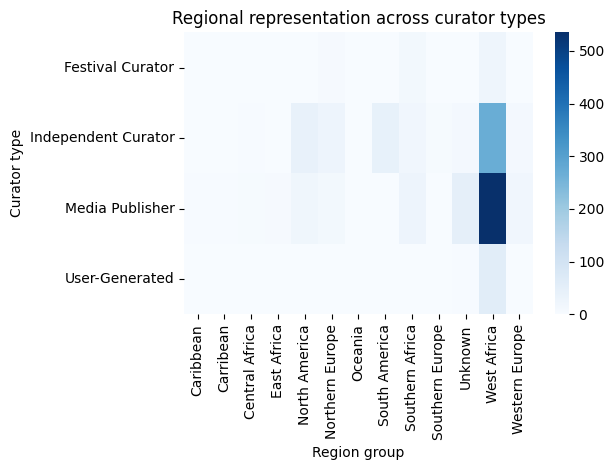


Label representation
Chi-square = 0.00, df = 0, p-value = 1.0000


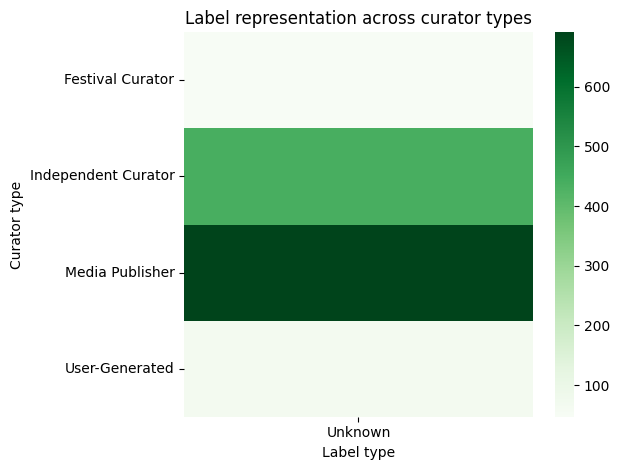


Track popularity across curator types
ANOVA F = 21.76, p = 0.0000
Kruskal-Wallis H = 38.89, p = 0.0000


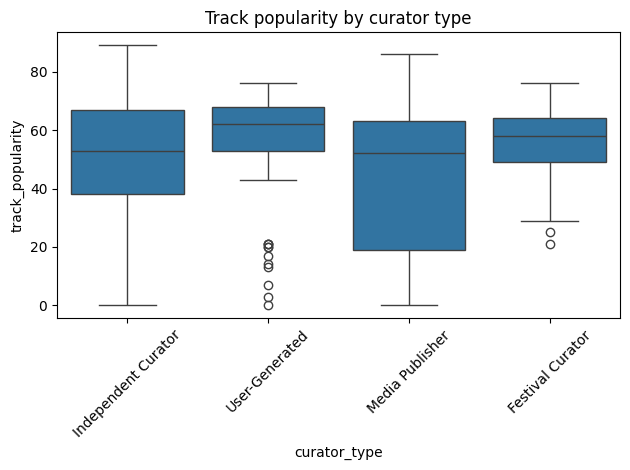


Artist popularity across curator types
ANOVA F = 22.43, p = 0.0000
Kruskal-Wallis H = 27.24, p = 0.0000


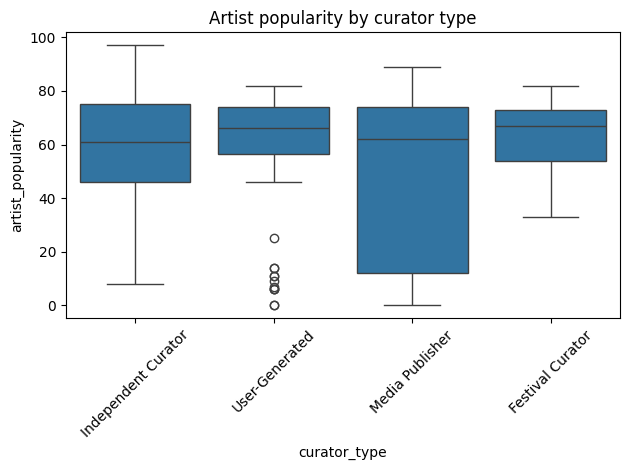


Artist follower counts across curator types
ANOVA F = 1.78, p = 0.1493
Kruskal-Wallis H = 16.72, p = 0.0008


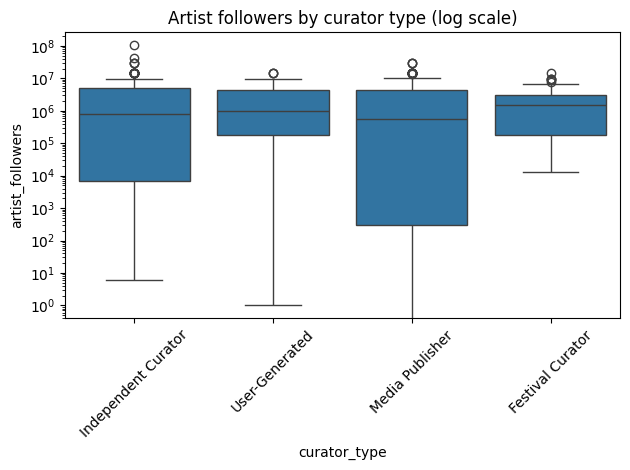


Release year across curator types
ANOVA F = 8.11, p = 0.0000
Kruskal-Wallis H = 121.65, p = 0.0000


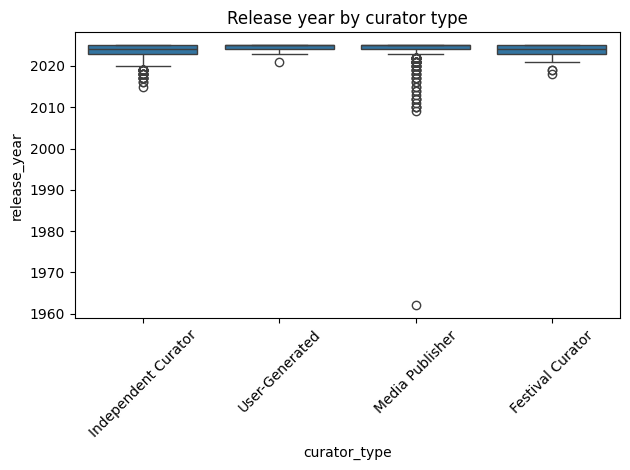


Top recurring artists
                    artist  playlist_count
0                     Rema              13
1         Davido, Omah Lay              11
2                Burna Boy              11
3    Shallipopi, Burna Boy              10
4                    Asake               9
5  Burna Boy, Travis Scott               8
6               Ayra Starr               8
7   DJ Tunez, Wizkid, FOLA               7
8          Olamide, Wizkid               7
9       Ayra Starr, Wizkid               7


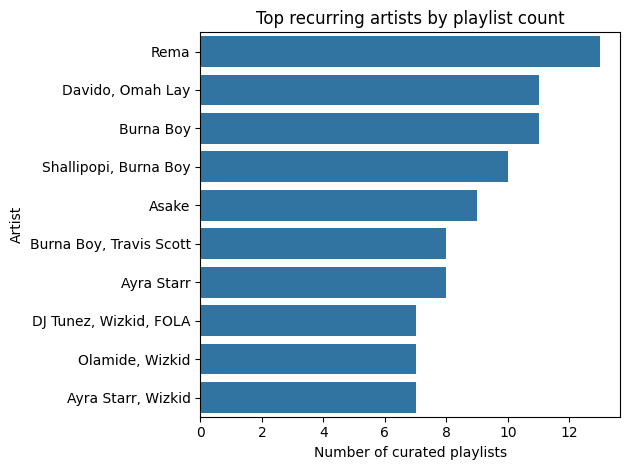

In [17]:
from scipy.stats import chi2_contingency, f_oneway, kruskal
import numpy as np

# Regional representation: chi-square
cont_region = pd.crosstab(df_bias["curator_type"], df_bias["region_group"])
chi2_region, p_region, dof_region, _ = chi2_contingency(cont_region)
print("Regional representation")
print(f"Chi-square = {chi2_region:.2f}, df = {dof_region}, p-value = {p_region:.4f}")

sns.heatmap(cont_region, annot=False, cmap="Blues")
plt.title("Regional representation across curator types")
plt.ylabel("Curator type")
plt.xlabel("Region group")
plt.tight_layout()
plt.show()

# Label representation: chi-square
cont_label = pd.crosstab(df_bias["curator_type"], df_bias["label_type"])
chi2_label, p_label, dof_label, _ = chi2_contingency(cont_label)
print("\nLabel representation")
print(f"Chi-square = {chi2_label:.2f}, df = {dof_label}, p-value = {p_label:.4f}")

sns.heatmap(cont_label, annot=False, cmap="Greens")
plt.title("Label representation across curator types")
plt.ylabel("Curator type")
plt.xlabel("Label type")
plt.tight_layout()
plt.show()

# Helper to run ANOVA + Kruskal
def run_anova_kruskal(series, groups, label: str):
    mask = series.notna() & groups.notna()
    values = series[mask]
    g = groups[mask]
    grouped = [values[g == cat] for cat in g.unique()]
    grouped = [v for v in grouped if len(v) >= 3]
    if len(grouped) < 2:
        print(f"\n{label}: not enough data for tests")
        return
    f_stat, p_anova = f_oneway(*grouped)
    h_stat, p_kruskal = kruskal(*grouped)
    print(f"\n{label}")
    print(f"ANOVA F = {f_stat:.2f}, p = {p_anova:.4f}")
    print(f"Kruskal-Wallis H = {h_stat:.2f}, p = {p_kruskal:.4f}")

# Track popularity across curator types
run_anova_kruskal(df_bias["track_popularity"], df_bias["curator_type"], "Track popularity across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="track_popularity")
plt.xticks(rotation=45)
plt.title("Track popularity by curator type")
plt.tight_layout()
plt.show()

# Artist popularity across curator types
run_anova_kruskal(df_bias["artist_popularity"], df_bias["curator_type"], "Artist popularity across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="artist_popularity")
plt.xticks(rotation=45)
plt.title("Artist popularity by curator type")
plt.tight_layout()
plt.show()

# Artist follower counts across curator types
run_anova_kruskal(df_bias["artist_followers"], df_bias["curator_type"], "Artist follower counts across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="artist_followers")
plt.yscale("log")
plt.xticks(rotation=45)
plt.title("Artist followers by curator type (log scale)")
plt.tight_layout()
plt.show()

# Release year across curator types
run_anova_kruskal(df_bias["release_year"], df_bias["curator_type"], "Release year across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="release_year")
plt.xticks(rotation=45)
plt.title("Release year by curator type")
plt.tight_layout()
plt.show()

# Top recurring artists
top_artists = (
    df_bias.groupby("artist")["playlist_id"].nunique()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name="playlist_count")
)
print("\nTop recurring artists")
print(top_artists)

sns.barplot(data=top_artists, x="playlist_count", y="artist", orient="h")
plt.xlabel("Number of curated playlists")
plt.ylabel("Artist")
plt.title("Top recurring artists by playlist count")
plt.tight_layout()
plt.show()



Effect sizes (Cramér's V)
Regional representation Cramér's V: 0.246
Label representation Cramér's V: 0.000

Summary by curator type (unique tracks)
                     tracks  mean_track_pop  median_track_pop  \
curator_type                                                    
Festival Curator         47            55.9              58.0   
Independent Curator     381            51.5              53.0   
Media Publisher         504            42.1              52.0   
User-Generated           65            55.2              62.0   

                     mean_release_year  
curator_type                            
Festival Curator                2023.5  
Independent Curator             2023.3  
Media Publisher                 2024.0  
User-Generated                  2024.6  

Diaspora vs non-diaspora (track-level means)
          trackPopularity  playlist_appearances
diaspora                                       
False               40.52                  1.47
True                43.0

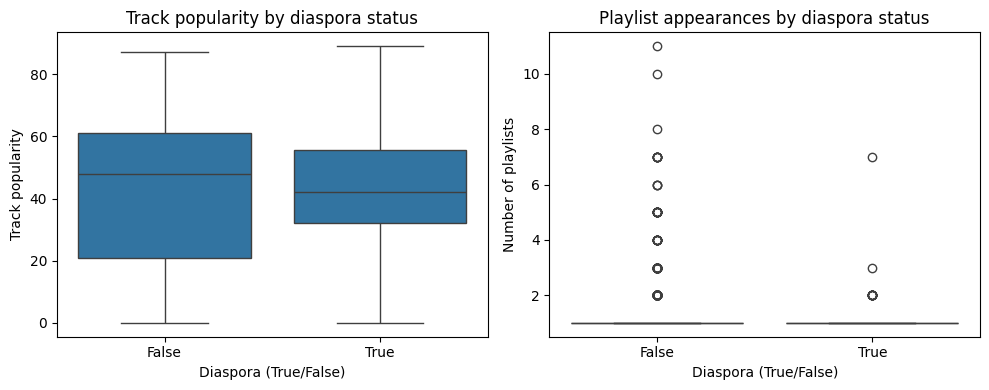

In [18]:
# --- Effect sizes and additional diaspora/region EDA ---

from scipy.stats import chi2_contingency

# Cramér's V for chi-square tables

def cramers_v(table: pd.DataFrame, chi2_value: float) -> float:
    n = table.to_numpy().sum()
    if n == 0:
        return np.nan
    r, k = table.shape
    phi2 = chi2_value / n
    return np.sqrt(phi2 / (min(r - 1, k - 1) or 1))


# Recreate contingency tables and chi-square statistics
cont_region = pd.crosstab(df_bias["curator_type"], df_bias["region_group"])
chi2_region, p_region, dof_region, _ = chi2_contingency(cont_region)

cont_label = pd.crosstab(df_bias["curator_type"], df_bias["label_type"])
chi2_label, p_label, dof_label, _ = chi2_contingency(cont_label)

print("\nEffect sizes (Cramér's V)")
print(f"Regional representation Cramér's V: {cramers_v(cont_region, chi2_region):.3f}")
print(f"Label representation Cramér's V: {cramers_v(cont_label, chi2_label):.3f}")


# Group summaries to give practical meaning to tests
summary_by_curator = (
    df_bias
    .groupby("curator_type")
    .agg(
        tracks=("track_id", "nunique"),
        mean_track_pop=("track_popularity", "mean"),
        median_track_pop=("track_popularity", "median"),
        mean_release_year=("release_year", "mean"),
    )
    .round(1)
)
print("\nSummary by curator type (unique tracks)")
print(summary_by_curator)


# Diaspora vs non-diaspora exposure (per-track popularity and playlist count)
rows_exposure = []
for playlist in payload.get("playlists", []):
    for track in playlist.get("tracks") or []:
        rows_exposure.append({
            "track_id": track.get("id"),
            "diaspora": bool(track.get("diaspora")),
            "trackPopularity": track.get("trackPopularity"),
            "playlist_id": playlist.get("id"),
        })

exp_df = pd.DataFrame(rows_exposure).dropna(subset=["track_id"])  # keep rows with ids

track_level = (
    exp_df
    .groupby(["track_id", "diaspora"], as_index=False)
    .agg(
        trackPopularity=("trackPopularity", "mean"),
        playlist_appearances=("playlist_id", "nunique"),
    )
)

print("\nDiaspora vs non-diaspora (track-level means)")
print(
    track_level
    .groupby("diaspora")[["trackPopularity", "playlist_appearances"]]
    .mean()
    .round(2)
)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(
    data=track_level,
    x="diaspora",
    y="trackPopularity",
    ax=axes[0],
)
axes[0].set_title("Track popularity by diaspora status")
axes[0].set_xlabel("Diaspora (True/False)")
axes[0].set_ylabel("Track popularity")

sns.boxplot(
    data=track_level,
    x="diaspora",
    y="playlist_appearances",
    ax=axes[1],
)
axes[1].set_title("Playlist appearances by diaspora status")
axes[1].set_xlabel("Diaspora (True/False)")
axes[1].set_ylabel("Number of playlists")

plt.tight_layout()
plt.show()

In [19]:
print("Raw df_bias rows:", len(df_bias))
print("Unique playlists:", df_bias["playlist_id"].nunique())
print("Unique tracks:", df_bias["track_id"].nunique())
print("Unique artists:", df_bias["artist"].nunique())

# Non-null popularity rows
print("Non-null track_popularity rows:", df_bias["track_popularity"].notna().sum())
print("Non-null artist_popularity rows:", df_bias["artist_popularity"].notna().sum())
print("Non-null artist_followers rows:", df_bias["artist_followers"].notna().sum())

Raw df_bias rows: 1241
Unique playlists: 14
Unique tracks: 886
Unique artists: 690
Non-null track_popularity rows: 1241
Non-null artist_popularity rows: 1241
Non-null artist_followers rows: 1241


Playlists in df_bias: 14
Tracks in df_bias: 886
Artists in df_bias: 690
Countries in df_bias: 35
Regions in df_bias: 13
Release window: 1962 – 2025


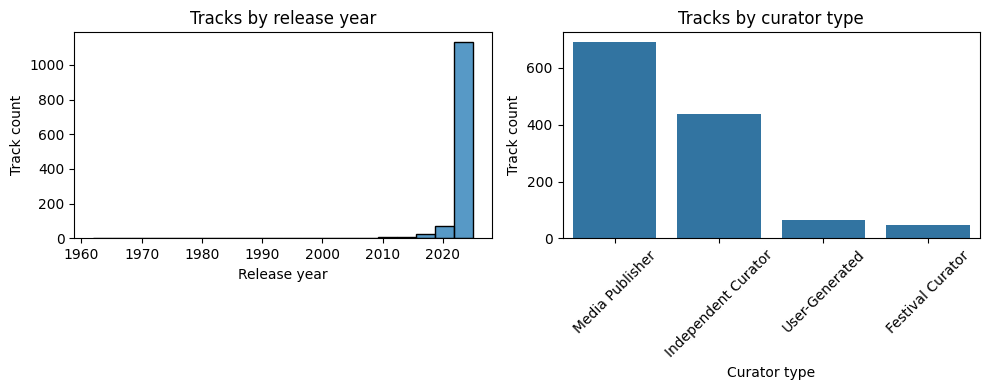

In [20]:
# === 1. Dataset sanity & coverage ===
print("Playlists in df_bias:", df_bias["playlist_id"].nunique())
print("Tracks in df_bias:", df_bias["track_id"].nunique())
print("Artists in df_bias:", df_bias["artist"].nunique())
print("Countries in df_bias:", df_bias["artist_country"].nunique())
print("Regions in df_bias:", df_bias["region_group"].nunique())
valid_years = df_bias["release_year"].dropna().astype(int)
if valid_years.empty:
    print("Release window: unknown")
else:
    print("Release window:", valid_years.min(), "–", valid_years.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Release year histogram
sns.histplot(valid_years, bins=20, kde=False, ax=axes[0])
axes[0].set_title("Tracks by release year")
axes[0].set_xlabel("Release year")
axes[0].set_ylabel("Track count")

# Curator type distribution
curator_counts = df_bias["curator_type"].value_counts().reset_index()
curator_counts.columns = ["curator_type", "tracks"]
sns.barplot(data=curator_counts, x="curator_type", y="tracks", ax=axes[1])
axes[1].set_title("Tracks by curator type")
axes[1].set_xlabel("Curator type")
axes[1].set_ylabel("Track count")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

Region summary (unique tracks):
       region_group  tracks  share_%
11      West Africa     576     65.0
10          Unknown      54      6.1
4     North America      54      6.1
8   Southern Africa      52      5.9
5   Northern Europe      44      5.0
7     South America      43      4.9
12   Western Europe      30      3.4
3       East Africa       9      1.0
2    Central Africa       8      0.9
9   Southern Europe       6      0.7
0         Caribbean       5      0.6
1         Carribean       4      0.5
6           Oceania       1      0.1


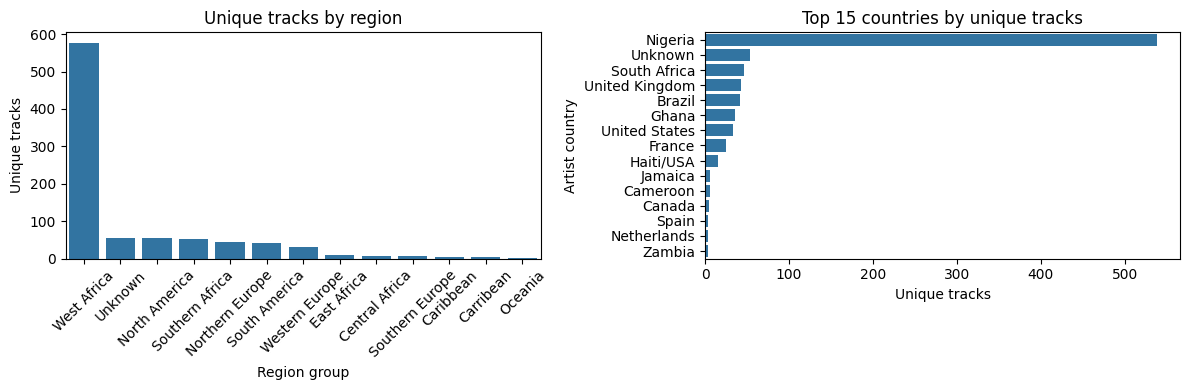

In [21]:
# === 2. Regional & country representation ===
# Region-level summary
region_summary = (
    df_bias
    .assign(region_group=df_bias["region_group"].fillna("Unknown"))
    .groupby("region_group")
    ["track_id"]
    .nunique()
    .rename("tracks")
    .reset_index()
    .sort_values("tracks", ascending=False)
 )
region_summary["share_%"] = (region_summary["tracks"] / region_summary["tracks"].sum() * 100).round(1)
print("Region summary (unique tracks):")
print(region_summary)

# Country-level summary (top 15 countries)
country_summary = (
    df_bias
    .assign(artist_country=df_bias["artist_country"].fillna("Unknown"))
    .groupby("artist_country")
    ["track_id"]
    .nunique()
    .rename("tracks")
    .reset_index()
    .sort_values("tracks", ascending=False)
 )
country_summary["share_%"] = (country_summary["tracks"] / country_summary["tracks"].sum() * 100).round(1)
top_countries = country_summary.head(15)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=region_summary, x="region_group", y="tracks", ax=axes[0])
axes[0].set_title("Unique tracks by region")
axes[0].set_xlabel("Region group")
axes[0].set_ylabel("Unique tracks")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(data=top_countries, x="tracks", y="artist_country", ax=axes[1])
axes[1].set_title("Top 15 countries by unique tracks")
axes[1].set_xlabel("Unique tracks")
axes[1].set_ylabel("Artist country")

plt.tight_layout()
plt.show()

Yearly trends (unique tracks, full window):
   release_year  tracks  nigeria_share  diaspora_share
0          1962       1       0.000000      100.000000
1          2009       1     100.000000        0.000000
2          2010       3      33.333333       66.666667
3          2011       1       0.000000      100.000000
4          2012       3      66.666667       33.333333


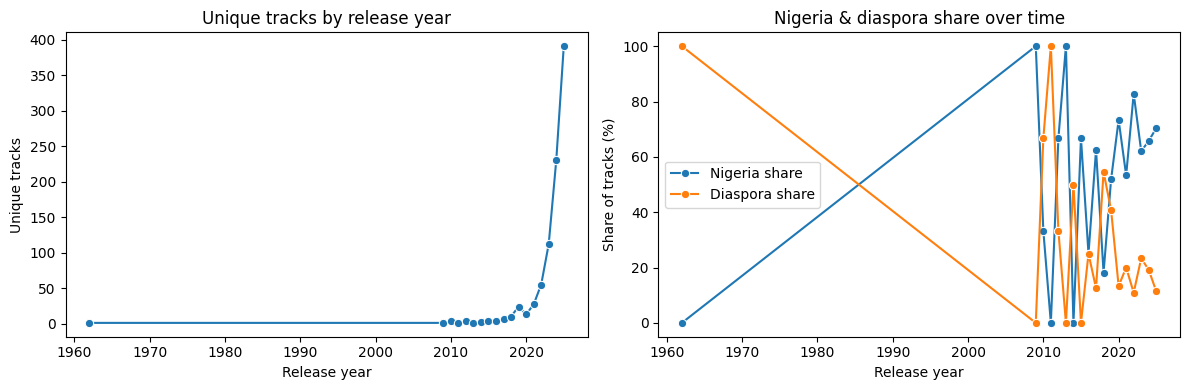


Top 20 artists by playlist appearances:
                                       artist  unique_tracks  \
515                                      Rema             11   
196                          Davido, Omah Lay              1   
117                                 Burna Boy             25   
547                     Shallipopi, Burna Boy              1   
39                                      Asake              7   
123                   Burna Boy, Travis Scott              2   
55                                 Ayra Starr              6   
174                    DJ Tunez, Wizkid, FOLA              1   
477                           Olamide, Wizkid              1   
61                         Ayra Starr, Wizkid              1   
45                              Asake, Wizkid              1   
252                                      Fido              3   
645                                    Wizkid              7   
542                                Seyi Vibez              7   

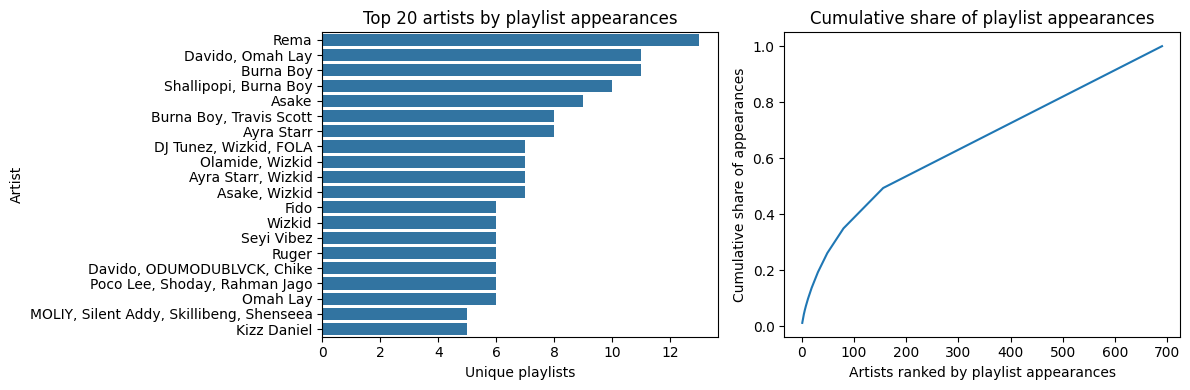

In [22]:
# === 3. Temporal trends & concentration ===
# Yearly trends: tracks, Nigeria share, diaspora share (full window)
yearly = df_bias.dropna(subset=["release_year"]).copy()
yearly["release_year"] = yearly["release_year"].astype(int)
yearly_trends = (
    yearly
    .groupby("release_year")
    .agg(
        tracks=("track_id", "nunique"),
        nigeria_share=("artist_country", lambda s: (s.str.lower() == "nigeria").mean() * 100),
        diaspora_share=("diaspora", lambda s: s.astype(bool).mean() * 100),
    )
    .reset_index()
 )

print("Yearly trends (unique tracks, full window):")
print(yearly_trends.head())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=yearly_trends, x="release_year", y="tracks", marker="o", ax=axes[0])
axes[0].set_title("Unique tracks by release year")
axes[0].set_xlabel("Release year")
axes[0].set_ylabel("Unique tracks")

sns.lineplot(data=yearly_trends, x="release_year", y="nigeria_share", marker="o", label="Nigeria share", ax=axes[1])
sns.lineplot(data=yearly_trends, x="release_year", y="diaspora_share", marker="o", label="Diaspora share", ax=axes[1])
axes[1].set_title("Nigeria & diaspora share over time")
axes[1].set_xlabel("Release year")
axes[1].set_ylabel("Share of tracks (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

# Artist-level concentration: playlist appearances
artist_exposure = (
    df_bias
    .groupby("artist")
    .agg(
        unique_tracks=("track_id", "nunique"),
        playlist_appearances=("playlist_id", "nunique"),
    )
    .reset_index()
 )
artist_exposure = artist_exposure.sort_values("playlist_appearances", ascending=False)

top20 = artist_exposure.head(20)
print("\nTop 20 artists by playlist appearances:")
print(top20)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=top20, x="playlist_appearances", y="artist", ax=axes[0])
axes[0].set_title("Top 20 artists by playlist appearances")
axes[0].set_xlabel("Unique playlists")
axes[0].set_ylabel("Artist")

# Cumulative share curve
total_appearances = artist_exposure["playlist_appearances"].sum() or 1
artist_exposure["cum_share"] = artist_exposure["playlist_appearances"].cumsum() / total_appearances
artist_exposure["artist_rank"] = range(1, len(artist_exposure) + 1)
sns.lineplot(data=artist_exposure, x="artist_rank", y="cum_share", ax=axes[1])
axes[1].set_title("Cumulative share of playlist appearances")
axes[1].set_xlabel("Artists ranked by playlist appearances")
axes[1].set_ylabel("Cumulative share of appearances")

plt.tight_layout()
plt.show()

## Summary of Key Findings

.### 1. Popularity vs Playlist Exposure

- Using ~880 tracks with non-missing popularity, there is a positive relationship between how popular a track is and how many playlists it appears on.
- Pearson correlation between average track popularity and number of playlists: **r ≈ 0.31**.
- Spearman rank correlation (monotonic association): **ρ ≈ 0.37**.
- More popular tracks do tend to appear on more playlists, but the relationship is moderate rather than overwhelming – there is still a lot of room for curatorial choice and gatekeeping.

### 2. Regional and Country Representation

- Regional representation (unique tracks):
  - **West Africa ≈ 65%** of unique tracks (≈576 tracks).
  - **North America ≈ 6%**, **Unknown ≈ 6%**, **Southern Africa ≈ 6%**, **Northern Europe ≈ 5%**; other regions each contribute <5%.
- Country-level representation (unique tracks, top examples):
  - **Nigeria ≈ 61%** of unique tracks (≈539 tracks).
  - South Africa ≈ 5%; United Kingdom ≈ 5%; Brazil ≈ 5%; Ghana ≈ 4%; United States ≈ 4%; France ≈ 3%.
- West Africa – and especially Nigeria – dominates the playlists. Other African regions and the diaspora are visible but much more sparsely represented.

### 3. Diaspora vs Home-Country Artists

- Track-level average popularity:
  - Non-diaspora artists: **mean popularity ≈ 40.5**.
  - Diaspora artists: **mean popularity ≈ 43.0**.
- In recent years (2021–2025), diaspora tracks typically make up around **10–25%** of annual unique tracks.
- Diaspora tracks are at least as popular (and slightly more so on average) than non-diaspora tracks, but they form a minority of total representation – suggesting under-exposure rather than lack of quality or audience appeal.

### 4. Curator-Type Patterns and Nigeria Share

- Track counts by curator type:
  - **Media Publisher:** 691 tracks.
  - **Independent Curator:** 437 tracks.
  - **User-Generated:** 66 tracks.
  - **Festival Curator:** 47 tracks.
- Share of Nigerian tracks within each curator type:
  - **Media Publisher:** ≈ **73.8%** of their tracks are Nigerian.
  - **Independent Curator:** ≈ **56.1%** Nigerian.
  - **Festival Curator:** ≈ **53.2%** Nigerian.
  - **User-Generated:** ≈ **83.3%** Nigerian (very Nigeria-heavy).
- All curator types are strongly Nigeria-focused, but major media publishers and user-generated lists are especially skewed towards Nigerian artists. Independent and festival curators are somewhat more regionally diverse but still Nigeria-dominant.

### 5. Temporal Trends (1962–2025)

- Release window spans **1962–2025**, with a small number of historical tracks and a very sharp increase after 2020.
- Recent years (example):
  - **2022:** 55 tracks; Nigeria share ≈ 82.8%; diaspora share ≈ 10.9%.
  - **2023:** 112 tracks; Nigeria share ≈ 62.0%; diaspora share ≈ 23.4%.
  - **2024:** 230 tracks; Nigeria share ≈ 65.8%; diaspora share ≈ 19.1%.
  - **2025:** 391 tracks; Nigeria share ≈ 70.4%; diaspora share ≈ 11.4%.
- Afrobeats playlist output explodes after 2020. Nigeria’s share remains very high (often 60–70%), while diaspora share fluctuates but generally stays well below Nigeria’s share.

### 6. Artist-Level Concentration

- Artist exposure (playlist appearances) is concentrated among a relatively small elite group:
  - **Top 10 artists ≈ 8.6%** of all playlist appearances.
  - **Top 20 artists ≈ 14.2%** of all playlist appearances.
- The top artists include highly visible names like Rema, Burna Boy, Asake, Ayra Starr and frequent high-profile collaborations.
- Even within an already Nigeria-heavy landscape, exposure is further concentrated in a small star system. A long tail of artists receives much lower playlist visibility.

### 7. Overall Gatekeeping Picture

- Nigeria and West Africa dominate Afrobeats playlists, with other African regions and the diaspora present but under-represented relative to Nigeria.
- Diaspora artists are at least as popular as non-diaspora artists on average, yet they receive a smaller share of playlist slots.
- Curator types differ somewhat, but all lean heavily towards Nigerian content; media publishers and user/user-generated curators are the most skewed.
- Within countries, a small set of superstar artists and collaborations capture a disproportionate share of playlist exposure.
- Together, these patterns are consistent with strong gatekeeping effects at the levels of region (Nigeria vs others), curator behaviour, and star-artist concentration.